# Finsler Fréchet Mean

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit
from jax import Array

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import pickle

import os

from load_manifold import load_manifold

from geometry.finsler.geodesics import GEORCE# GEORCE_AdaFM
from geometry.riemannian.manifolds import nEllipsoid, nParaboloid, HyperbolicParaboloid
from geometry.finsler.manifolds import RiemannianNavigation

2025-02-06 03:34:53.422694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
device = 'gpu'
geometry = "finsler"
batch_size = '10'
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/finsler/frechet/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [5]:
def load_manifold_data(manifold:str, dim):
    
    save_path = ''.join((path, manifold, '/'))
    
    onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
    onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]
    
    estimates = {}
    for file in onlyfiles:
        file_path = ''.join((save_path, file))
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        method = file.split(f'_{manifold}')[0]
        dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
        if dim in estimates:
            estimates[dim] = dict(estimates[dim], **values)
        else:
            estimates[dim] = values
            
    return estimates
    

In [55]:
ellipsoid_data = load_manifold_data("Ellipsoid", 2)
sphere_data = load_manifold_data("Sphere", 2)
paraboloid_data = load_manifold_data("Paraboloid", 2)
hyppar_data = load_manifold_data("HyperbolicParaboloid", 2)

## Functions

In [56]:
def force_fun(z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return jnp.sin(z)*val/val2
    
v0 = 1.5

## Loading Estimates and Data

In [57]:
ellipsoid_method = load_manifold_data("Ellipsoid", dim=2)['2']
sphere_method = load_manifold_data("Sphere", dim=2)['2']
#paraboloid_method = load_manifold_data("Paraboloid", 2)['2']
#hyperbolic_paraboloid_method = load_manifold_data("HyperbolicParaboloid", 2)['2']

In [58]:
ellipsoid_data, M_ellipsoid, _ = load_manifold("Ellipsoid", dim=2, N_data=100)
sphere_data, M_sphere, _ = load_manifold("Sphere", dim=2, N_data=100)
paraboloid_data, M_paraboloid, _ = load_manifold("Paraboloid", dim=2, N_data=100)
hyppar_data, M_hyppar, _ = load_manifold("HyperbolicParaboloid", dim=2, N_data=100)

## Computing Connecting Geodesics

In [59]:
def connecting_geodesics_fun(z_mu, z_obs, RM):
    
    M = RiemannianNavigation(RM=RM,
                             force_fun=lambda z: force_fun(z, RM),
                             v0=v0,
                            )
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=100,
                      max_iter=10,
                      line_search_method="soft",
                      line_search_params = {'rho':0.5},
                     )
    
    zt_geodesic = vmap(Geodesic, in_axes=(None,0))(z_mu, z_obs)
    
    return zt_geodesic
    

In [71]:
ellipsoid_geodesics = connecting_geodesics_fun(ellipsoid_method['GEORCE_FM']['mu'],
                                               ellipsoid_data,
                                               M_ellipsoid,
                                              )
ellipsoid_geodesics = vmap(vmap(M_ellipsoid.f))(ellipsoid_geodesics)

In [72]:
sphere_geodesics = connecting_geodesics_fun(sphere_method['GEORCE_FM']['mu'],
                                            sphere_data,
                                            M_sphere,
                                           )
sphere_geodesics = vmap(vmap(M_sphere.f))(sphere_geodesics)

In [ ]:
paraboloid_geodesics = connecting_geodesics_fun(paraboloid_method['GEORCE_FM']['mu'],
                                                paraboloid_data,
                                                M_paraboloid,
                                               )
paraboloid_geodesics = vmap(vmap(M_paraboloid.f))(paraboloid_geodesics)

In [ ]:
hyppar_geodesics = connecting_geodesics_fun(hyppar_method['GEORCE_FM']['mu'],
                                            hyppar_data,
                                            M_hyppar,
                                           )
hyppar_geodesics = vmap(vmap(M_hyppar.f))(hyppar_geodesics)

## Plotting the Frechet Mean

In [112]:
class EllipsoidPlot(ABC):
    def __init__(self, 
                 params=jnp.linspace(0.5,1.0,3)[::-1],
                ):
        
        self.M = nEllipsoid(dim=2, params=params)
        self.force_fun = lambda z: force_fun(z, self.M)
        self.params = params

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [113]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        self.M = nParaboloid(dim=2)
        self.force_fun = lambda z: force_fun(z, self.M)
        
        return
    
    def heat_map(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return X1, X2, X1**2+X2**2, force

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [114]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        self.M = HyperbolicParaboloid(dim=2)
        self.force_fun = lambda z: force_fun(z, self.M)
        
        return
    
    def heat_map(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return X1, X2, X1**2+X2**2, force

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

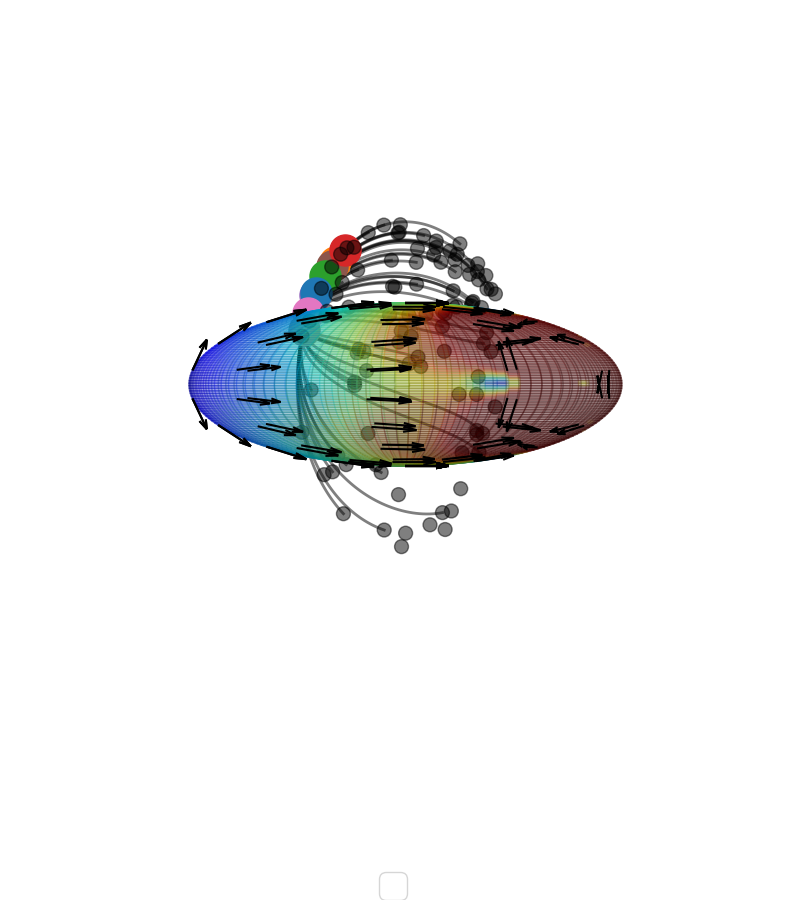

In [120]:
fig = plt.figure(figsize=(10,10))

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for geo in ellipsoid_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=0.5,
            linewidth=2.0,
            color='black',
           )
for key, vals in ellipsoid_method.items():
    mu = M_ellipsoid.f(vals['mu'])
    ax.scatter(mu[0],
               mu[1],
               mu[2],
               s=500,
              )    
obs = vmap(M_ellipsoid.f)(ellipsoid_data)
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='black', alpha=0.5, s=100)
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

NameError: name 'gfkgflgkflg' is not defined

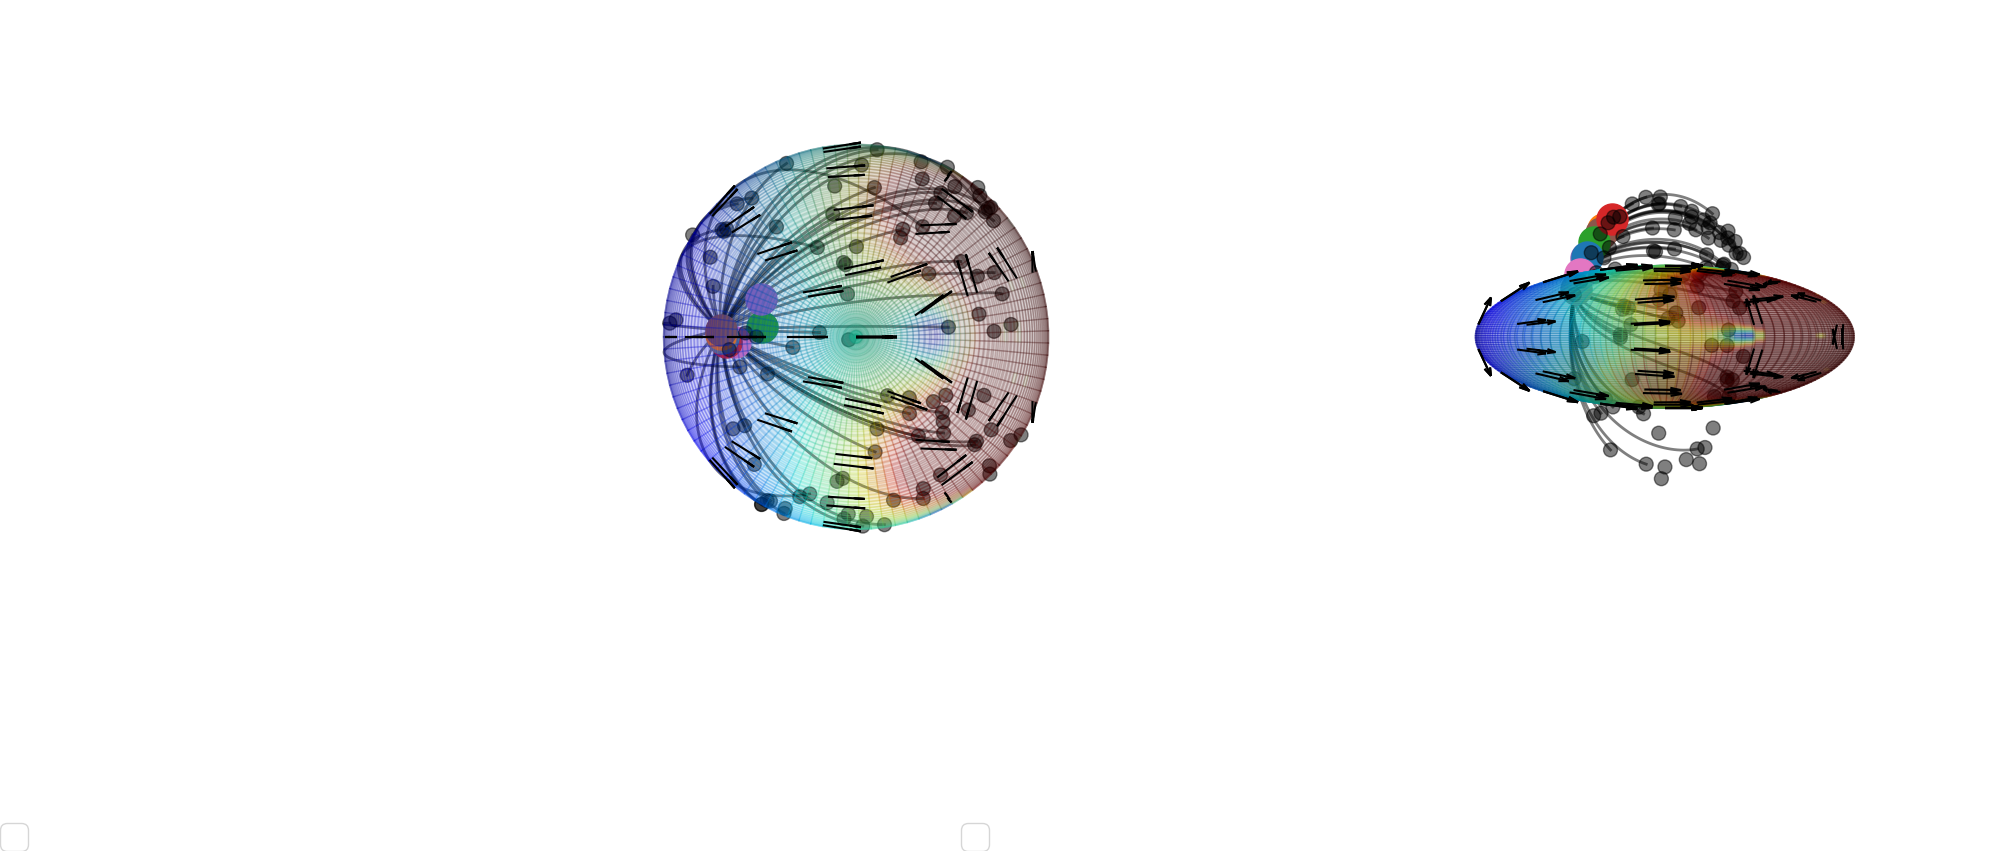

In [116]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.1,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for geo in sphere_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=0.5,
            linewidth=2.0,
            color='black',
           )
for key, vals in sphere_method.items():
    mu = M_sphere.f(vals['mu'])
    ax.scatter(mu[0],
               mu[1],
               mu[2],
               s=500,
              )    
obs = vmap(M_sphere.f)(sphere_data)
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='black', alpha=0.5, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=90., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for geo in ellipsoid_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=0.5,
            linewidth=2.0,
            color='black',
           )
for key, vals in ellipsoid_method.items():
    mu = M_ellipsoid.f(vals['mu'])
    ax.scatter(mu[0],
               mu[1],
               mu[2],
               s=500,
              )    
obs = vmap(M_ellipsoid.f)(ellipsoid_data)
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='black', alpha=0.5, s=100)
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

print(gfkgflgkflg )

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in paraboloid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.0), ncol=1)


#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in ellipsoid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(e2_x0[0], e2_x0[1], e2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(e2_xT[0], e2_xT[1], e2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

#plotting Torus
plot_sphere = TorusPlot(R=3.0, r=1.0)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)


for key, value in torus_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(t2_x0[0], t2_x0[1], t2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(t2_xT[0], t2_xT[1], t2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.70, 0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}synthetic_finsler_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()



### Ellipsoid(2)

In [9]:
z_obs, RM, _ = load_manifold(manifold="Sphere", dim=2, sigma=1.0, N_data=10)
theta = jnp.linspace(0, 2*jnp.pi, N_data, endpoint=False)
z_obs = jnp.vstack((jnp.cos(theta), jnp.sin(theta))).T
z0 = -jnp.linspace(0,1,2)
z_obs = z0+jrandom.normal(key, shape=(N_data,2))
x_obs = vmap(RM.f)(z_obs)

x_obs = 0.1*jnp.vstack((jnp.cos(theta), jnp.sin(theta), jnp.ones(N_data))).T
x_obs = x_obs.T/jnp.linalg.norm(x_obs, axis=1)
x_obs = x_obs.T

z_obs = vmap(RM.invf)(x_obs)

In [10]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [11]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=1000,
                        tol = 1e-4,
                        line_search_params={'rho': rho},
                       )

In [12]:
ellipsoid_mean = FrechetMean(z_obs, z_mu_init = z_obs[0], step="while")

In [16]:
jnp.linalg.norm(ellipsoid_mean[2])

Array(7.9290854e-05, dtype=float32)

In [18]:
ellipsoid_mean[0]

Array([-2.4164681e-08,  7.2818255e-01], dtype=float32)

In [17]:
ellipsoid_mean[-1]

Array(2, dtype=int32, weak_type=True)

In [ ]:
M.length_frechet(ellipsoid_mean[1], z_obs, ellipsoid_mean[0])

In [ ]:
ellipsoid_mean = FrechetMean(z_obs, z_mu_init = None, step="while")

In [ ]:
jnp.linalg.norm(ellipsoid_mean[2])

In [85]:
ellipsoid_mean[-1]

Array(1, dtype=int64, weak_type=True)

In [86]:
M.length_frechet(ellipsoid_mean[1], z_obs, ellipsoid_mean[0])

Array(0.41990886, dtype=float64)

In [62]:
ellipsoid_mean[0]

Array([ 0.18750552, -0.89880491], dtype=float64)

In [63]:
M.length_frechet(ellipsoid_mean[1][::-1], z_obs, ellipsoid_mean[0])

Array(18.86218152, dtype=float64)

In [64]:
ellipsoid_mean[-1]

Array(0, dtype=int64, weak_type=True)

In [65]:
z_obs[0]

Array([-0.66445816, -1.71001253], dtype=float64)

In [26]:
jnp.mean(z_obs, axis=0)

Array([-3.7394853 ,  1.10119509], dtype=float64)

In [27]:
jnp.linalg.norm(ellipsoid_mean[-2])

Array(0.0675403, dtype=float64)

In [38]:
ellipsoid_mean[0]

Array([-3.86952185,  0.68427241], dtype=float64)

In [296]:
ellipsoid_zt_init = FrechetMean.init_curve(z_obs, z_obs[0])
ellipsoid_xt_init = vmap(vmap(M.f))(zt_init)
ellipsoid_obj_init = M.length_frechet(zt_init, z_obs, z_obs[0])

NameError: name 'zt_init' is not defined

In [14]:
xt_geodesics = vmap(vmap(vmap(M.f)))(fmean[1])
xt_fm = vmap(M.f)(fmean[0])
dist = vmap(lambda zt, z_mu: M.length_frechet(zt, z_obs, z_mu))(fmean[1], fmean[0])

In [22]:
ellipsoid_methods = compute_methods(M, z0, zT, rho=0.5)

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


### $\mathbb{S}^{2}$

In [15]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

In [24]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [25]:
sphere_methods = compute_methods(M, z0, zT, rho=0.5)

### Paraboloid(2)

In [26]:
RM = nParaboloid(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2)

p2_x0 = RM.f(z0)
p2_xT = RM.f(zT)

In [27]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [28]:
paraboloid_methods = compute_methods(M, z0, zT, rho=0.5)

### $\mathbb{T}^{2}$

In [29]:
RM = T2(R=3.0, r=1.0)
z0 = jnp.array([0.0, 0.0])
zT = jnp.array([5*jnp.pi/4, 5*jnp.pi/4])

t2_x0 = RM.f(z0)
t2_xT = RM.f(zT)

In [30]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [31]:
torus_methods = compute_methods(M, z0, zT, rho=0.5)

### Generate data

In [46]:
N_data = 10

In [47]:
RM = nSphere(dim=2)

In [48]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [49]:
theta = jnp.linspace(0, 2*jnp.pi, N_data, endpoint=False)
#z0 = -jnp.linspace(0,1,2)
#z_obs = z0+jrandom.normal(key, shape=(N_data,2))
#x_obs = vmap(RM.f)(z_obs)

x_obs = 0.1*jnp.vstack((jnp.cos(theta), jnp.sin(theta), jnp.ones(N_data))).T
x_obs = x_obs.T/jnp.linalg.norm(x_obs, axis=1)
x_obs = x_obs.T

z_obs = vmap(RM.invf)(x_obs)

### Computing Fréchet Mean

In [50]:
iters = 3
T = 100
tol = 1e-4
rho = 0.95

In [51]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=iters,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [52]:
fmean = FrechetMean(z_obs, step="for")

In [23]:
vmap(M.f)(fmean[0])

Array([[ 2.3182474e-01, -1.2004812e-09,  9.7275752e-01],
       [ 2.9677197e-01,  3.3560667e-08,  9.5494843e-01],
       [ 2.9689527e-01,  3.3715814e-08,  9.5491010e-01]], dtype=float32)

In [43]:
FrechetMean = GEORCE_AdaFM(M=M,
                            init_fun=None,
                           alpha=0.9,
                            T=T,
                            max_iter=iters,
                           sub_iter=5,
                            tol = tol,
                           conv_flag=1.0,
                            line_search_params={'rho': 0.95},
                           )

In [44]:
fmean = FrechetMean(z_obs, batch_size=None, step="for")

In [45]:
vmap(M.f)(fmean[0])

Array([[ 3.1774315e-01, -2.9608377e-10,  9.4817686e-01],
       [ 3.1774315e-01, -9.8441433e-10,  9.4817686e-01],
       [ 3.1774315e-01, -9.8441433e-10,  9.4817686e-01]], dtype=float32)

In [53]:
zt_init = FrechetMean.init_curve(z_obs, z_obs[0])[:,::-1]
xt_init = vmap(vmap(M.f))(zt_init)
obj_init = M.length_frechet(zt_init, z_obs, z_obs[0])

In [54]:
xt_geodesics = vmap(vmap(vmap(M.f)))(fmean[1])
xt_fm = vmap(M.f)(fmean[0])
dist = vmap(lambda zt, z_mu: M.length_frechet(zt, z_obs, z_mu))(fmean[1], fmean[0])

### Plotting

In [55]:
class EllipsoidPlot(ABC):
    def __init__(self, 
                 params=jnp.linspace(0.5,1.0,3)[::-1],
                ):
        
        self.M = nEllipsoid(dim=2, params=params)
        self.force_fun = lambda z: force_fun(z, self.M)
        self.params = params

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

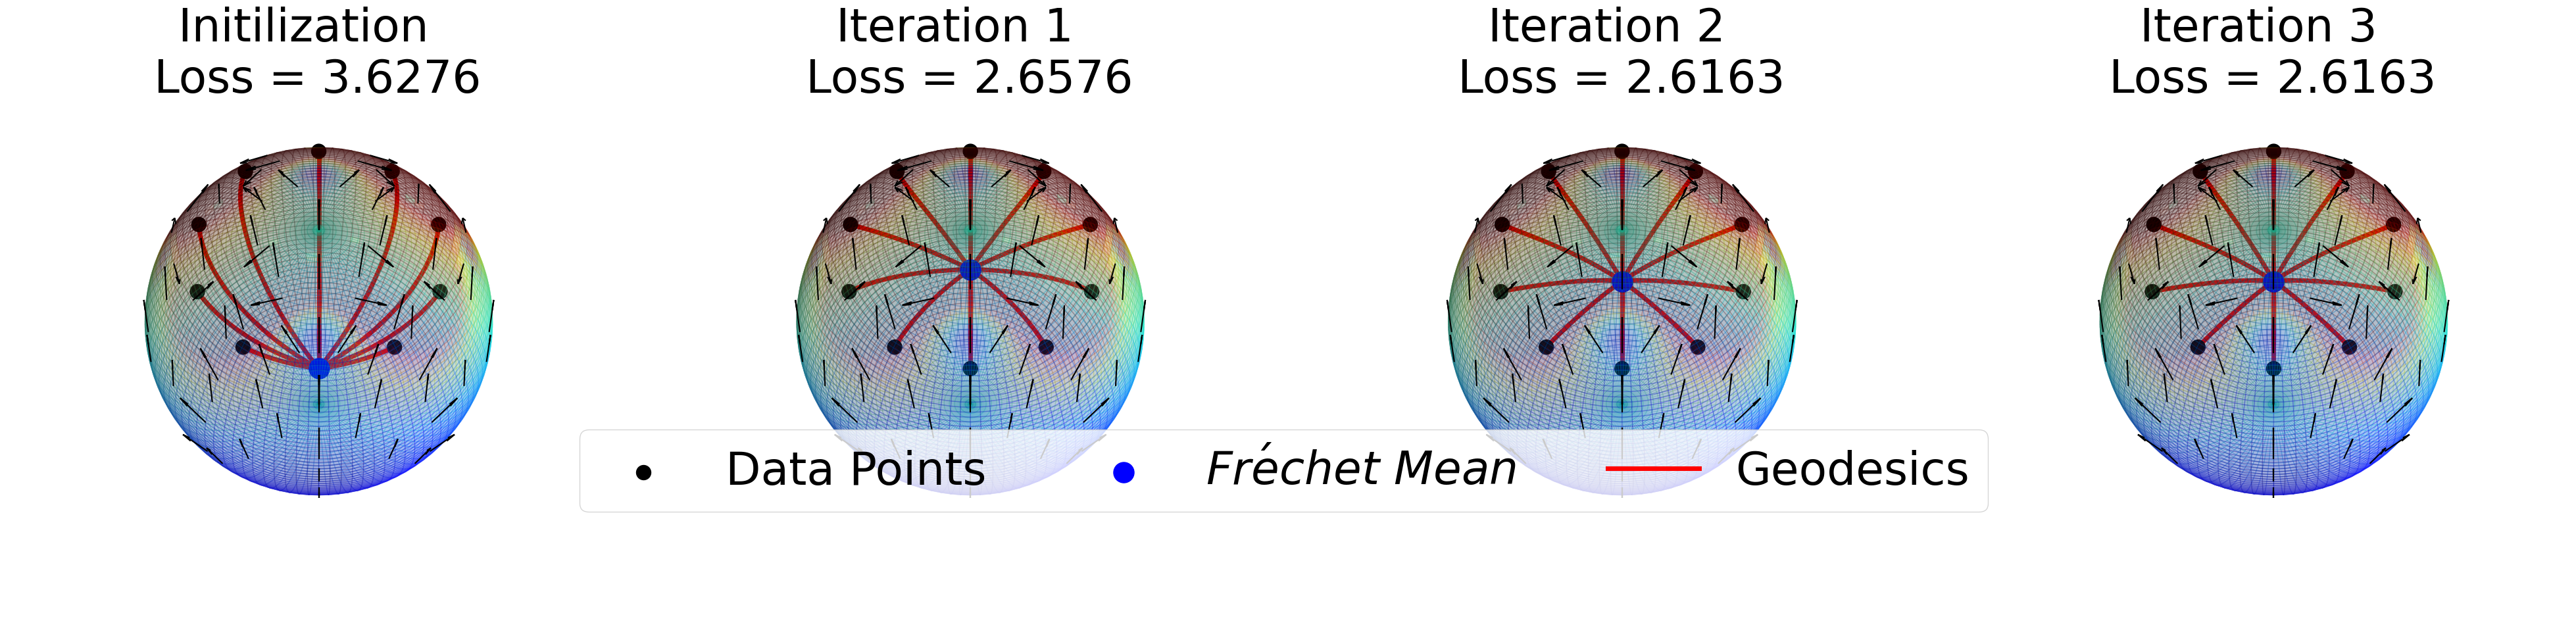

In [56]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)

ax = fig.add_subplot(1,4,1, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)

ax.scatter(x_obs[:,0], x_obs[:,1], x_obs[:,2], color='black', alpha=1.0, s=250)
ax.scatter(x_obs[0,0], x_obs[0,1], x_obs[0,2], color='blue', alpha=1.0, s=500)
for v1 in xt_init:
    ax.plot(v1[:,0], v1[:,1], v1[:,2], color='red', alpha=1.0, linewidth=5.0)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0.)
ax.set_title(f"Initilization \n Loss = {obj_init:.4f}", y=1.0, pad=-20, fontsize=50)

for i in range(3):
    ax = fig.add_subplot(1,4,i+2, projection='3d')
    ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
    ax.quiver(field[0], field[1], field[2], 
              field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)

    ax.scatter(x_obs[:,0], x_obs[:,1], x_obs[:,2], color='black', alpha=1.0, s=250)
    ax.scatter(xt_fm[i][0], xt_fm[i][1], xt_fm[i][2], color='blue', alpha=1.0, s=500)
    for v1 in xt_geodesics[i]:
        ax.plot(v1[:,0], v1[:,1], v1[:,2], color='red', alpha=1.0, linewidth=5.0)
    ax.set_box_aspect([1,1,1])
    ax.set_xlim([-1.0,1.0])
    ax.set_ylim([-1.0,1.0])
    ax.set_zlim([-1.0,1.0])
    ax.set_axis_off()
    ax.set_title(f"Iteration {i+1} \n Loss = {dist[i]:.4f}", y=1.0, pad=-20, fontsize=50)
    ax.view_init(elev=60., azim=0.)
    
ax.scatter([],[],[], color="black", alpha=1.0, s=250, label="Data Points")
ax.scatter([],[],[], color="blue", alpha=1.0, s=500, label=r"$Fr\'echet$ $Mean$")
ax.plot([],[],[], color="red", alpha=1.0, linewidth=5.0, label=r"Geodesics")

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.225, 0.2), ncol=3, fontsize=50)
    
fig.tight_layout()

save_path = f'{figure_path}conceptual_finsler_frechet.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Information Geometry with Fisher-Rao metric

In [ ]:
N_data = 10

In [ ]:
max_iter = 1000
T = 100
tol = 1e-2
rho = 0.95
std = 0.1

### Gaussian Distribution

#### Generate Data

In [ ]:
M = FisherRaoGeometry(distribution='Gaussian')
z0 = jnp.array([-1.0, 0.5])
z1 = jnp.array([1.0, 1.0])

In [27]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [28]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
gaussian_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [20]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        line_search_method="soft",
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [21]:
fgaussian = FrechetMean(gaussian_data, step="while")

In [22]:
gaussian_dist = M.length_frechet(fgaussian[1], gaussian_data, fgaussian[0])

In [23]:
gaussian_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_gaussian(x,
                                                         jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                               mu+3*sigma,
                                                                                               100)))(gaussian_data[:,0],
                                                                                                      gaussian_data[:,1])

gaussian_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                    mu+3*sigma,
                                                    100))(gaussian_data[:,0],
                                                          gaussian_data[:,1])

In [24]:
mu, sigma = fgaussian[0][0], fgaussian[0][1]
gaussian_fmpdf = vmap(lambda x: M.pdf_gaussian(x,jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                          mu+3*sigma,
                                                                          100))
gaussian_fmgrid = jnp.linspace(mu-3*sigma,mu+3*sigma,100)

### Frechet Distribution

In [25]:
M = FisherRaoGeometry(distribution='Frechet')
z0 = jnp.array([0.5, 0.5])
z1 = jnp.array([1.0, 1.0])

In [26]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [27]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
frechet_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [28]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        line_search_method="soft",
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [29]:
ffrechet = FrechetMean(frechet_data, step="while")

In [30]:
frechet_dist = M.length_frechet(ffrechet[1], frechet_data, ffrechet[0])

In [31]:
frechet_pdf = vmap(lambda beta,lam: vmap(lambda x: \
                                 M.pdf_frechet(x,jnp.hstack((beta,lam))))(jnp.linspace(0.01,
                                                                                    3.0,
                                                                                        100)))(frechet_data[:,0],
                                                                                               frechet_data[:,1])
frechet_grid = vmap(lambda beta, lam: jnp.linspace(0.01,
                                             3.0,
                                             100))(frechet_data[:,0],
                                                   frechet_data[:,1])

In [32]:
beta, lam = ffrechet[0][0], ffrechet[0][1]
frechet_fmpdf =  vmap(lambda x: M.pdf_frechet(x,jnp.hstack((beta,lam))))(jnp.linspace(0.01,3.0,100))
frechet_fmgrid = jnp.linspace(0.01,3.0,100)

### Cauchy Distribution

In [33]:
M = FisherRaoGeometry(distribution='Cauchy')
z0 = jnp.array([-1.0, 0.5])
z1 = jnp.array([1.0, 1.0])

In [34]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [35]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
cauchy_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [36]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        line_search_method="soft",
                        max_iter=max_iter,
                        tol = 1e-4,
                        line_search_params={'rho': rho},
                       )

In [37]:
fcauchy = FrechetMean(cauchy_data, step="while")

In [38]:
cauchy_dist = M.length_frechet(fcauchy[1], cauchy_data, fcauchy[0])

In [39]:
cauchy_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_cauchy(x,
                                                       jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                             mu+3*sigma,
                                                                                             100)))(cauchy_data[:,0],
                                                                                                    cauchy_data[:,1])
cauchy_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                  mu+3*sigma,
                                                  100))(cauchy_data[:,0],
                                                        cauchy_data[:,1])

In [40]:
mu, sigma = fcauchy[0][0], fcauchy[0][1]
cauchy_fmpdf =  vmap(lambda x: M.pdf_cauchy(x,jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                    mu+3*sigma,
                                                                                    100))
cauchy_fmgrid = jnp.linspace(mu-3*sigma,mu+3*sigma,100)

### Pareto Distribution

In [41]:
M = FisherRaoGeometry(distribution='Pareto')
z0 = jnp.array([0.5, 0.5])
zT = jnp.array([1.0, 1.0])

In [42]:
key = jrandom.PRNGKey(seed)
eps = 0.5*jrandom.normal(key, shape=(N_data//2, M.dim))

In [43]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
pareto_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [44]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        line_search_method="soft",
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [45]:
fpareto = FrechetMean(pareto_data, step="while")

In [46]:
pareto_dist = M.length_frechet(fpareto[1], pareto_data, fpareto[0])

In [47]:
pareto_pdf = vmap(lambda theta,alpha: vmap(lambda x: \
                                 M.pdf_pareto(x,jnp.hstack((theta,alpha))))(jnp.linspace(0.5,
                                                                                        2.0,
                                                                                        100)))(pareto_data[:,0],
                                                                                               pareto_data[:,1])
pareto_grid = vmap(lambda theta, alpha: jnp.linspace(0.5,
                                             2.0,
                                             100))(pareto_data[:,0],
                                                   pareto_data[:,1])

In [48]:
theta, alpha = fpareto[0][0], fpareto[0][1]
pareto_fmpdf =  vmap(lambda x: M.pdf_pareto(x,jnp.hstack((theta,alpha))))(jnp.linspace(0.5,
                                                                                        2.0,
                                                                                        100))
pareto_fmgrid = jnp.linspace(0.5,2.0,100)

### Plotting

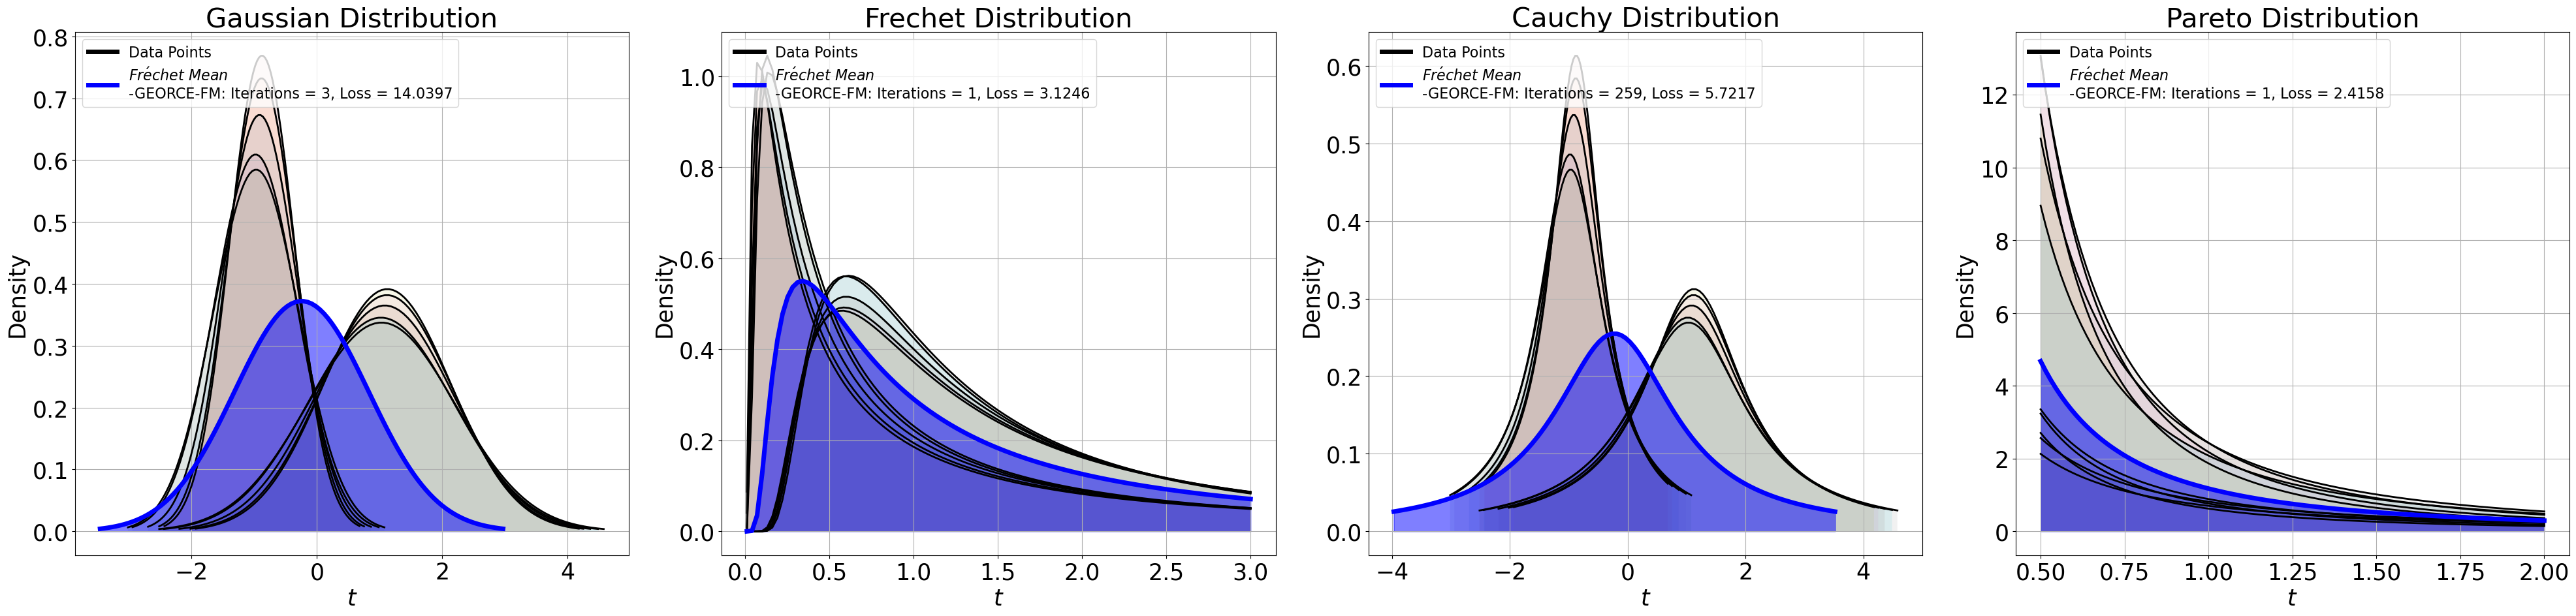

In [49]:
fig = plt.figure(figsize=(40,10))

#Gaussian
ax = fig.add_subplot(141)
for grid, pdf in zip(gaussian_grid, gaussian_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(gaussian_fmgrid, gaussian_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fgaussian[-1]}, Loss = {gaussian_dist:.4f}")
ax.fill_between(gaussian_fmgrid, 
                gaussian_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Gaussian Distribution')
ax.grid(True)

#Frechet
ax = fig.add_subplot(142)
for grid, pdf in zip(frechet_grid, frechet_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(frechet_fmgrid, frechet_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {ffrechet[-1]}, Loss = {frechet_dist:.4f}")
ax.fill_between(frechet_fmgrid, 
                frechet_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Frechet Distribution')
ax.grid(True)

#Cauchy
ax = fig.add_subplot(143)
for grid, pdf in zip(cauchy_grid, cauchy_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(cauchy_fmgrid, cauchy_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fcauchy[-1]}, Loss = {cauchy_dist:.4f}")
ax.fill_between(cauchy_fmgrid, 
                cauchy_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Cauchy Distribution')
ax.grid(True)

#Pareto
ax = fig.add_subplot(144)
for grid, pdf in zip(pareto_grid, pareto_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(pareto_fmgrid, pareto_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fpareto[-1]}, Loss = {pareto_dist:.4f}")
ax.fill_between(pareto_fmgrid, 
                pareto_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Pareto Distribution')
ax.grid(True)

fig.tight_layout()
save_path = f'{figure_path}information_geometry_frechet_mean.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()